In [2]:
from sklearn import ensemble, cross_validation, learning_curve, metrics 
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve

import numpy as np
import pandas as pd

from sklearn import datasets

from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

** Helper functions **

In [3]:
def fit_model(X,y,name_suffix,cfg_s,extra_params=''):
    d_filename = 'data/xy_train_'+name_suffix+'.csv'
    m_filename = 'data/model_'+name_suffix+'.mm'
    cfg_filename = 'data/'+name_suffix+'.cfg'
    
    df = pd.DataFrame(data=np.hstack( (X,y[:,None]) ))
    df.to_csv(d_filename)

    with open(cfg_filename,'wb') as file:
        file.write(cfg_s)

    !build/genetic_progr -d $d_filename -f $m_filename --cfg $cfg_filename $extra_params

    print
    !cat $m_filename

In [4]:
def get_prediction(X_test,name_suffix):
    
    d_filename = 'data/x_test_'+name_suffix+'.csv'
    m_filename = 'data/model_'+name_suffix+'.mm'
    cfg_filename = 'data/'+name_suffix+'.cfg'
    pred_filename = 'data/y_pred_'+name_suffix+'.csv'
    
    
    df_ = pd.DataFrame(data=X_test)
    df_.to_csv(d_filename)

    !build/genetic_progr -d $d_filename -t -i $m_filename --cfg $cfg_filename -p $pred_filename

    with open(pred_filename,'rb') as file:
        a = file.read()
        y_pred = np.array([float(t) for t in a.split()])
        
    return y_pred

# 1. Elementary functions

## a) sin + cos: regression

** As a first example we will use a composition of elementary functions sin and cos with some added noise.**

In [5]:
np.random.seed(1)
x = np.arange(-5,5,0.5,dtype=float)
y = np.sin(x)+np.cos(x)+np.random.rand(x.size)

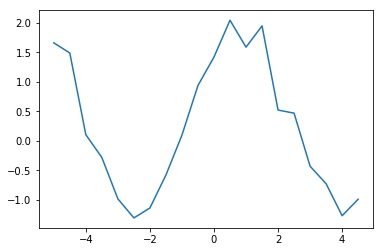

In [6]:
plt.plot(x,y)
plt.show()

** We will now fit the model to the above data. "genetic_progr" takes a GP-config file as an ouput which we will set as shown below - as a text. This way, it is easier to play with numbers right from the Jupyter cell. **

In [7]:
## This is written to the cfg-file for "genetic_progr"
cfg_s= '''ntrees = 500
max_depth=2
max_depth_ex = 5
ngen_max=5000
err_thr = 0
lambda=0.4
ratio_ss=0.1
func_prob=0.85
term_const_prob=0.1
consts_min=-1
consts_max=1
consts_n=1000
loss_function=squared'''

In [8]:
## Launch "genetic_progr" and show the resulting function
fit_model(x[:,None],y,'sin',cfg_s,'--random_seed=1')

 
fit progress: 100% 
* min err = 3.86974 
fitting time = 3.86 
number of cross-overs = 1229 
err(last best_tree) = 3.86974 

(cos(x[0])+sin(x[0]))


** Looks like the algorithm managed to find the underlying function **

** We will test the resulting model by showing the output of the final predictor on the same x range. **

In [9]:
## get prediction from "genetic_progr" on the same x as in the training
y_pred = get_prediction(x[:,None],'sin')

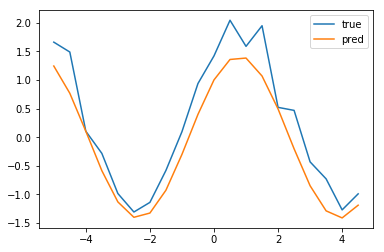

In [10]:
plt.plot(x,y,label="true")
plt.plot(x,y_pred,label="pred")
plt.legend()
plt.show()

## b) quadratic function: binary classification

** Another example of data generated with elemetary functions will be used for the classification problem. The workflow is analogous to the previous example. **

In [11]:
## using standard dataset
circles = datasets.make_circles(n_samples=100, noise=0.15, random_state=0)
#circles = datasets.make_circles(n_samples=1000)
X = circles[0]
y = circles[1]

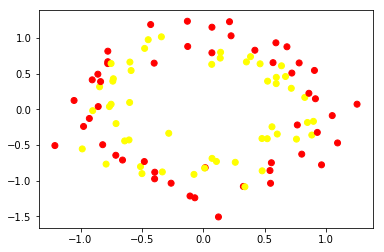

In [12]:
colors = ListedColormap(['red', 'yellow'])
plt.scatter(X[:,0],X[:,1], c = y, cmap = colors)

In [13]:
# Classes ratio is 50%
y.sum()*1./y.size

0.5

In [14]:
cfg_s='''ntrees = 10000
max_depth=3
max_depth_ex = 7
ngen_max=5000
err_thr = 0
lambda=0.4
ratio_ss=0.01
func_prob=0.83
term_const_prob=0.1
consts_min=-1
consts_max=1
consts_n=1000
loss_function=squared'''

In [15]:
fit_model(X,y,'circles',cfg_s,'--random_seed=1')

 
fit progress: 100% 
* min err = 71.1963 
fitting time = 4.619 
number of cross-overs = 1031 
acc_oob(last best_tree) = 0.75 

sin(cos(pow2(x[0]))-(pow2(x[1])+pow2(x[0])))


** We will now test the model. First, we predict on training X, to see (and measure) the fit quality **

In [16]:
X_test = X

In [17]:
y_pred = get_prediction(X_test,'circles')

In [18]:
y_1 = np.where(y==0,-1,1)
accuracy_score(y_1,y_pred)

0.75

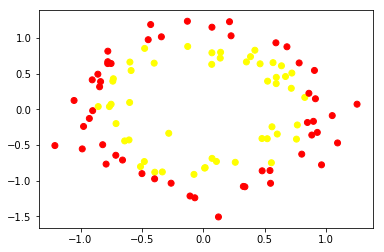

In [19]:
colors = ListedColormap(['red', 'yellow'])
plt.scatter(X_test[:,0], X_test[:,1], c = y_pred, cmap = colors)

** Now, we want to vizualize the predictor "everywhere", that is in the entire X range [-1..1, -1..1] **

In [20]:
# Generating new test objects
X_test = np.random.rand(1000,2)*2-1

In [21]:
y_pred = get_prediction(X_test,'circles')

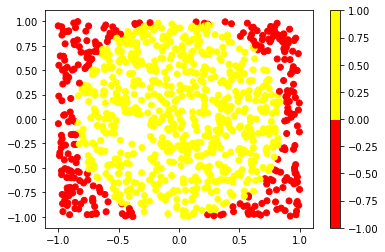

In [22]:
pcm = plt.scatter(X_test[:,0], X_test[:,1], c = y_pred,cmap=colors,vmin=-1,vmax=1)
plt.colorbar(pcm)
plt.show()

** The graph above shows that the predictor generally captures the shapes of the regions belonging to the classes -1 and 1, which is a satisfactory generalization in this case. **

** Lets compare the decision boundary with the one from a standard algorithm, e.g. random forest. ** 

In [23]:
## Init, fit, and get score
clf_rf = rf(n_estimators = 50, max_depth = 5, random_state = 1)
clf_rf.fit(X,y)
accuracy_score(y,clf_rf.predict(X))

0.89000000000000001

** RF fits the data better. Sill, our aim is to compare the decision boundaries. **

In [24]:
# Getting rf's prediction on full range X_test
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf = np.where(y_pred_rf==0,-1,1)

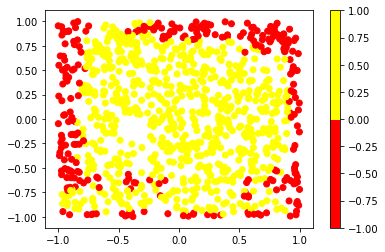

In [25]:
X_ = X_test
y_pred_ = y_pred_rf

pcm = plt.scatter(X_[:,0], X_[:,1], c = y_pred_,cmap=colors,vmin=-1,vmax=1)
plt.colorbar(pcm)
plt.show()

** Looks like the decision boundary from the genetic_progr is of a simpler shape ** 

# 2. Bioresponse data

The dataset for this case is taken from https://www.kaggle.com/c/bioresponse/data, and the data deescription can be found here https://www.kaggle.com/c/bioresponse#description.
The task is to relate the molecular information to an actual biological response. The response is given in the column "Activity", and the rest of the columns represent molecular properties.

In [26]:
df = pd.read_csv('data/bioresponse.csv', header=0, sep=',')

In [27]:
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Extracting features X and the target y

In [28]:
y = df.Activity.values

In [29]:
print 'y==0: {:.2f}'.format(np.sum(y==0)*1./df.shape[0])
print 'y==1: {:.2f}'.format(np.sum(y==1)*1./df.shape[0])

y==0: 0.46
y==1: 0.54


we have a balanced sample

In [30]:
X = df.ix[:,1:].values

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=1)

For a reference, we will use a standard classifier (random forest).

In [32]:
clf_rf = rf(n_estimators = 50, max_depth = 10, random_state = 1)

In [33]:
cross_val_score(clf_rf,X_train,y_train)

array([ 0.76255708,  0.77142857,  0.79061785])

In [34]:
clf_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [35]:
y_pred_rf = clf_rf.predict(X_test)

In [36]:
accuracy_score(y_test,y_pred_rf)

0.78507992895204259

Now, the result with the GP algorithm

In [37]:
cfg_s= '''ntrees = 20000
max_depth=7
max_depth_ex = 12
ngen_max=20000
err_thr = 0
lambda=0.4
ratio_ss=0.01
func_prob=0.83
term_const_prob=0.1
consts_min=-1
consts_max=1
consts_n=1000
loss_function=squared'''

In [38]:
fit_model(X_train,y_train,'bio',cfg_s,'--random_seed=1')

 
fit progress: 100% 
* min err = 1970.3 
fitting time = 287.911 
number of cross-overs = 3600 
acc_oob(last best_tree) = 0.73181 

tanh((x[468]-x[132])+sin((tanh(x[26]-x[8])-x[132])+x[145]))


In [39]:
y_pred = get_prediction(X_test,'bio')

In [40]:
y_test_ = np.where(y_test==0,-1,1)
accuracy_score(y_test_,y_pred)

0.74955595026642985

** We've got an accuracy score of nearly 0.75 with only 6 variables (468, 132, 26, 8, 132, 145) out of 1777. **